# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install top2vec
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [23]:
from top2vec import Top2Vec

import os
import spacy
import unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Data and sources


## Prints for Koppermaandag
From the 18th century onwards, so called "Koppermaandagprenten" are retained in cultural heritage institutes. These prints are a proof of the quality of printing that a printshop was able to deliver. The labourers of a printshop made a print and brought them to the customers, expecting them to buy the print, or give a tip. This extra income was used to buy drinks on "Koppermaandag", a celebration on the first Monday after Epiphany.

In 1991, an important publication is made about this type of printwork, with an overview of the retained Koppermaandagprenten. From this book the counts per year are available.

In [24]:
prentenDF = pd.read_csv("data/koppermaandagprentenCount.csv", index_col="year")

print("Number of prints: "+ str(prentenDF['count'].sum()))


Number of prints: 554


## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [30]:
liedjesDF = pd.read_csv("data/liedjes.csv", dtype={'jaartal': 'Int32'})
liedjesDF = liedjesDF.sort_values(by=['songID'])

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    744
Number of booklets:  61


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [27]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(" ".join(new_text)) # add text to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords: list 
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfTexts, replaceDict, removeList):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.split()
        preprocessedLiedje = remove(replace(liedje, replaceDict), removeList)
        result.append(" ".join(preprocessedLiedje))

    return result

We use the above functions to read the lyrics.

In [28]:
liedjesFilenames    = getlistOfFilenames('data/lyrics')
liedjes             = getlistOfTexts(liedjesFilenames)
lemmatizedLiedjes   = lemmatize(liedjes, select = False)

replaceDict = {"koster":"coster", "costers":"coster", "kosters":"coster", "vreugd":"vreugde", "blijd":"blijde"}
removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden", "uw", "staan", "waarmee", "immer", "t", "d", "wijze", "hurah"]

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList)

To investigate whether our code has worked, we look at the data of song with number ```n```.

In [32]:
n = 446

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- path: --")
print(liedjesFilenames[n])
print("-- song: --")
print(liedjes[n])
print("-- lemmatized song: --")
print(lemmatizedLiedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                     middelburg1847
sourceID                   middelburg1847-feestbundel1864
songID                  middelburg1847-feestbundel1864-36
titel                                          Triomfzang
wijze                                                 NaN
jaartal                                              1855
schrijver                                             NaN
vereniging_schrijver                       middelburg1847
Name: 431, dtype: object
-- path: --
data/lyrics/middelburg1847/middelburg1847-feestbundel1864/middelburg1847-feestbundel1864-36.txt
-- song: --
Triomfzang.

Triomf! de nacht der duisternis,
Werd eens door Costers vond verbroken,
Hij heeft het eerste licht ontstoken,
Waardoor zijn naam onsterfelijk is.
Komt, kunstgenooten!
Zingt victorie,
Zijn naam blinkt steeds in ’s lands historie
Met luister door tot ’t laatste nageslacht;
Eeuw in eeuw uit zal steeds de drukkunst pralen
Tot Neêrlands roem, tot Costers glorie.

-- le

# Count 
The development of the number of particular retained heritage of printing in the nineteenth century might say something about the change of relevance for printers to create these prints. In this notebook the development of printing heritage is investigated.



## Number of Koppermaandagprenten per year
First, we study the number of Koppermaandagprenten per year. We smooth the count with a five year rolling mean. We observe two timeperiods where the making of these prints was popular: the 1820's and between 1840-1860.

<AxesSubplot: xlabel='year'>

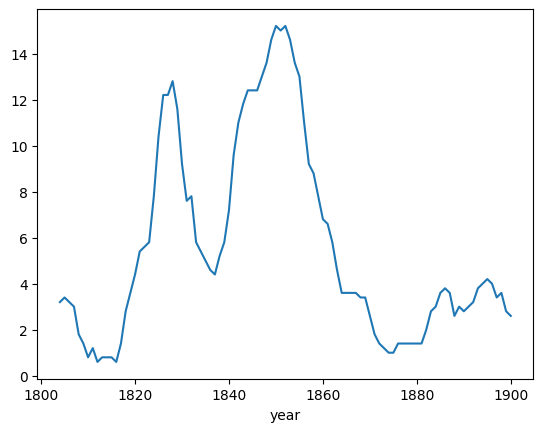

In [33]:
prentenDF['count'].rolling(5).mean().plot()

## Number of songs and number of words per year
Secondly, we want to investigate how much songs are in the dataset per year. We smooth the outcome again with a five years rolling mean. We observe a popularity for creating songs between 1850 en 1865.

<AxesSubplot: xlabel='jaartal'>

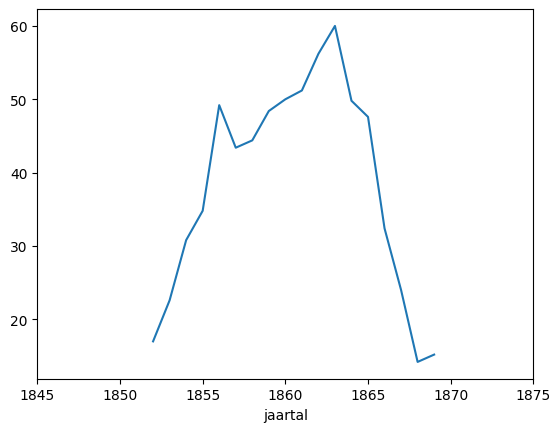

In [34]:
liedjesDF.groupby('jaartal').size().rolling(5).mean().plot(xlim=(1845,1875))

We study the number of words per year, instead of the number of songs per year for a potentially more precise indication. We calculate the number of words per song and add this to the liedjes DataFrame.

(array([ 0.,  0.,  2.,  3.,  3.,  4.,  9., 17., 18., 39., 27., 57., 67.,
        79., 57., 45., 39., 41., 43., 30., 29., 24., 15., 23., 18., 14.,
         6.,  7.,  6.,  5.,  2.,  2.,  1.,  3.,  2.,  1.,  1.,  0.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195.]),
 <BarContainer object of 39 artists>)

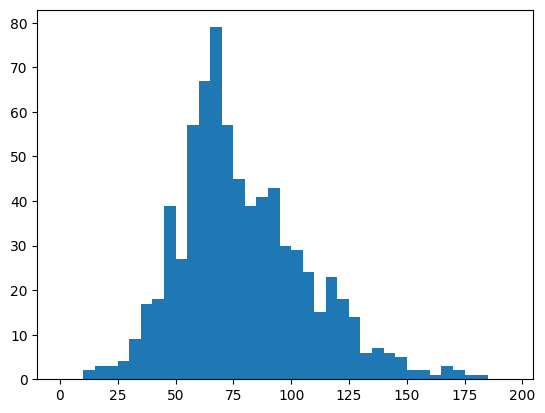

In [35]:
numberOfSongs = len(liedjes)

listOfWordlists = [] 
for i in range(0,numberOfSongs): listOfWordlists.append(preprocessedLiedjes[i].split())

listOfWordcounts = []
for i in range(0,numberOfSongs): listOfWordcounts.append(len(listOfWordlists[i]))

plt.hist(listOfWordcounts, bins=range(0,200,5), range=[0,200])


In [36]:
liedjesDF['wordcount'] = listOfWordcounts
liedjesDF.iloc[n]


typoID                                     middelburg1847
sourceID                   middelburg1847-feestbundel1864
songID                  middelburg1847-feestbundel1864-36
titel                                          Triomfzang
wijze                                                 NaN
jaartal                                              1855
schrijver                                             NaN
vereniging_schrijver                       middelburg1847
wordcount                                              30
Name: 431, dtype: object

<AxesSubplot: xlabel='jaartal'>

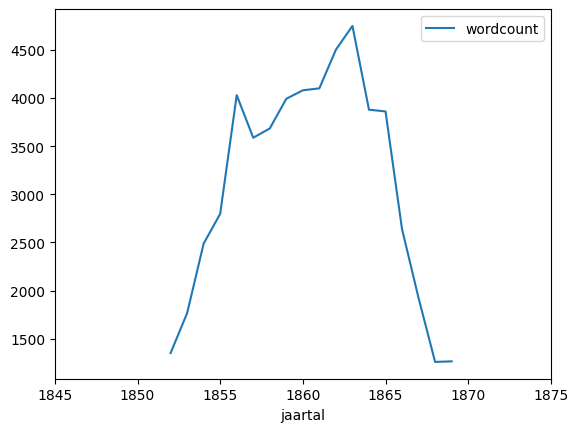

In [14]:
liedjesDF.groupby('jaartal').sum('wordcount').rolling(5).mean().plot(xlim=(1845,1875))

## Average size of a song per year
So the number of songs and the total number of words in the lyrics per year does not differ that much. How about the average size of a song per year? 

<AxesSubplot: xlabel='jaartal'>

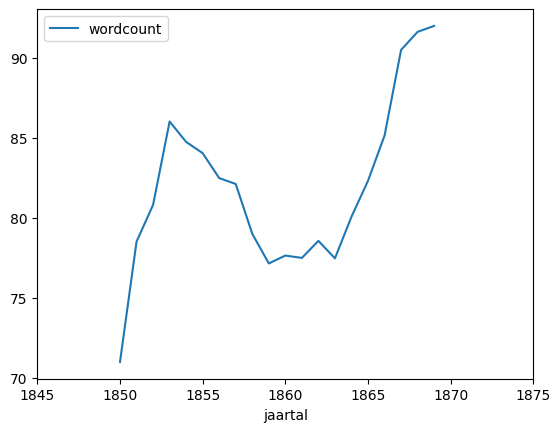

In [37]:
liedjesDF.groupby('jaartal').mean('wordcount').rolling(3).mean().plot(xlim=(1845,1875))

## Number of booklets per year
The number of booklets per year. Some booklets contain larger collections of songs through time of one typographical association (Middelburg) or of various associations on one moment (on the occasion of the erection of the statue of Coster in Haarlem 1856). We create a slice of the DataFrame without these books (with more than 50 songs) to have a better overview of the books created by associations in their own reasons. For the same reason we remove from this slice the singular songs that are retained over time (so we select booklets we at least 3 songs).

<AxesSubplot: xlabel='year'>

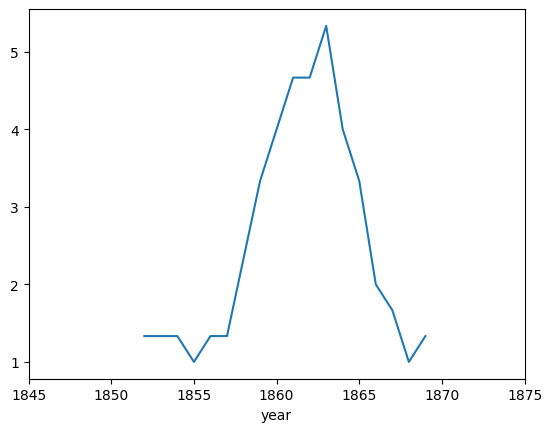

In [38]:
boekjesDF    = pd.read_csv('data/boekjes.csv')
boekjesSlice = boekjesDF.loc[boekjesDF['size'] < 50].loc[boekjesDF['size'] > 2]
boekjesSlice.groupby('year').size().rolling(3).mean().plot(xlim=(1845,1875))

## Compare the number of Koppermaandagprenten with the number of songs

<AxesSubplot: xlabel='year'>

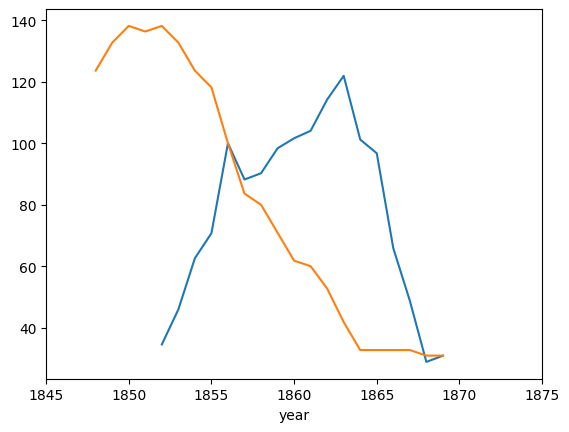

In [39]:
liedjesSerie = liedjesDF.groupby('jaartal').size().rolling(5).mean()
prentenSerie = prentenDF['count'].rolling(5).mean()

n = 1856

indexCijfersLiedjes = []
for year in range(1848,1870): indexCijfersLiedjes.append((liedjesSerie.loc[year] / liedjesSerie.loc[n]) * 100)

indexCijfersPrenten = []
for year in range(1848,1870): indexCijfersPrenten.append((prentenSerie.loc[year] / prentenSerie.loc[n]) * 100)

indexCijfersDF = pd.DataFrame()
indexCijfersDF['year'] = range(1848,1870)
indexCijfersDF['liedjesIndex'] = indexCijfersLiedjes
indexCijfersDF['prentenIndex'] = indexCijfersPrenten

indexCijfersDF = indexCijfersDF.set_index('year')
indexCijfersDF['liedjesIndex'].plot(xlim=(1845,1875))
indexCijfersDF['prentenIndex'].plot(xlim=(1845,1875))




## Average size of booklets per year, in number of songs and number of words

# Topics with Top2Vec
Do the topics of songs change over time?

In [40]:
model = Top2Vec(preprocessedLiedjes)

2023-01-13 14:03:50,034 - top2vec - INFO - Pre-processing documents for training
2023-01-13 14:03:50,157 - top2vec - INFO - Creating joint document/word embedding
2023-01-13 14:03:51,483 - top2vec - INFO - Creating lower dimension embedding of documents
2023-01-13 14:03:58,280 - top2vec - INFO - Finding dense areas of documents
2023-01-13 14:03:58,299 - top2vec - INFO - Finding topics


In [41]:
model.topic_sizes

0    344
1    303
2     97
dtype: int64

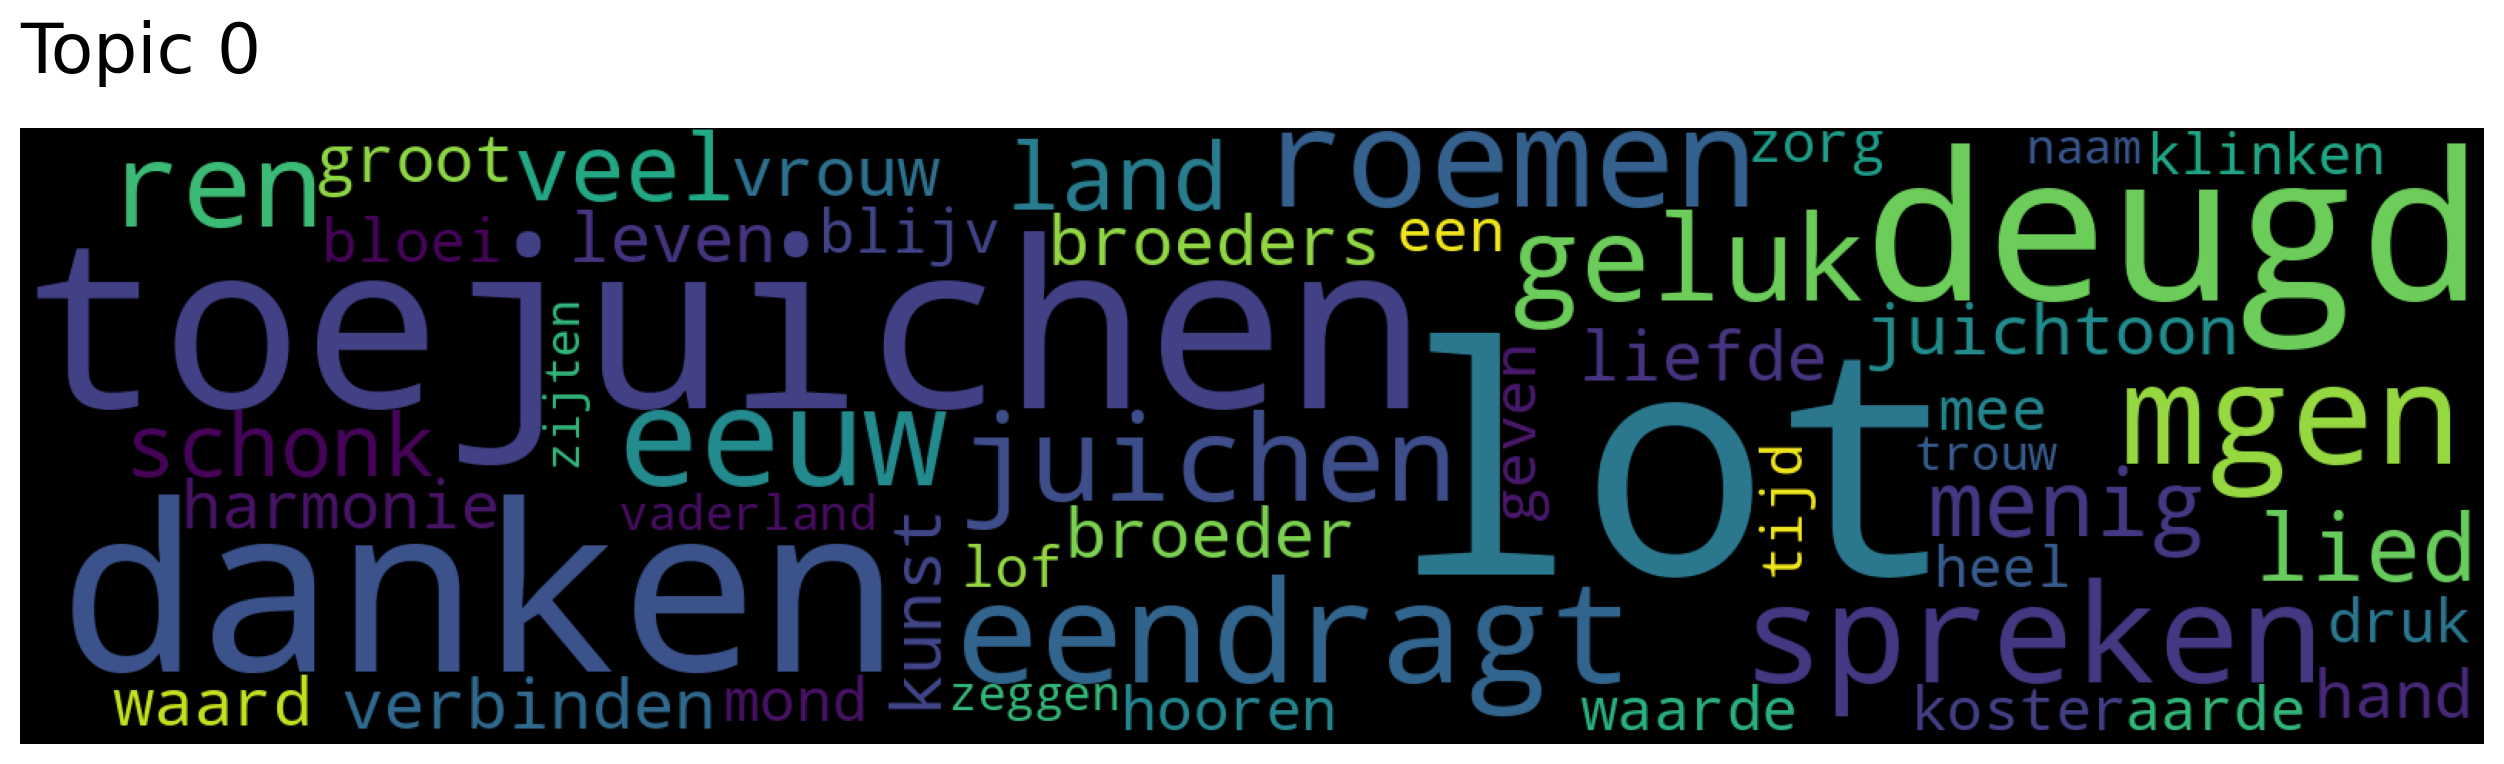

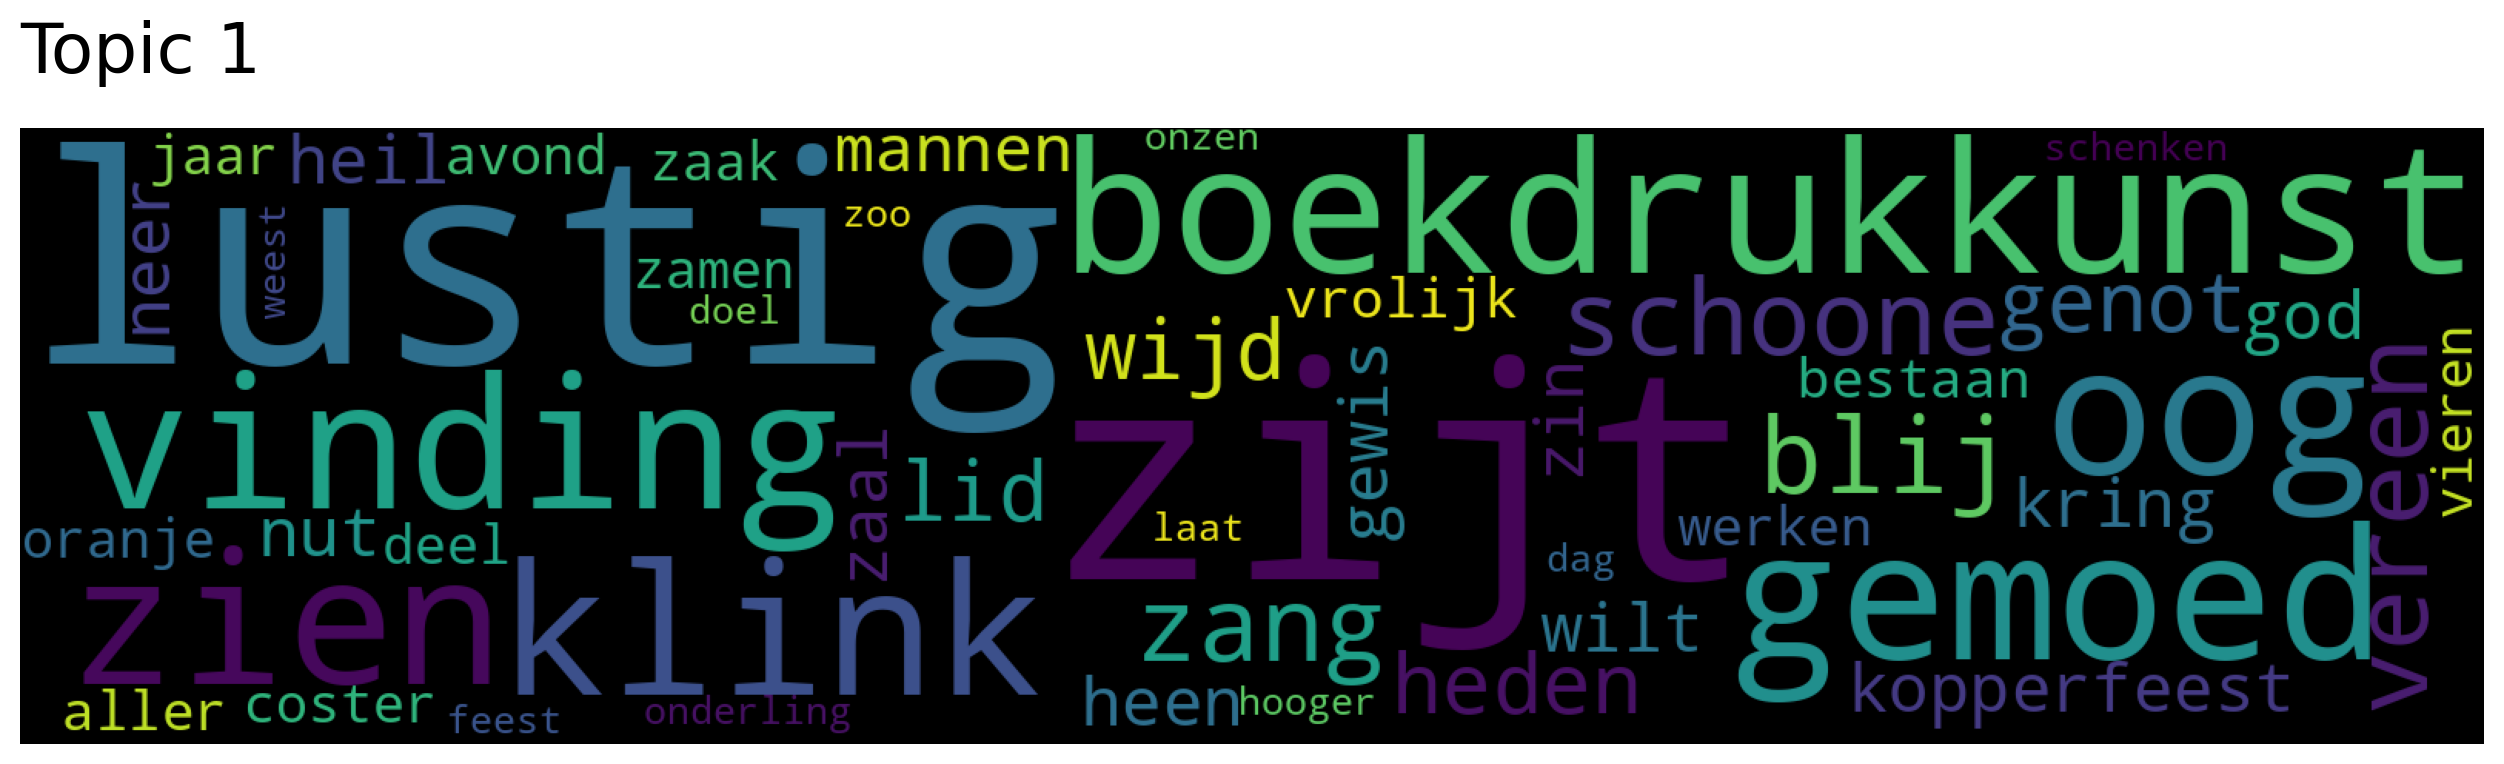

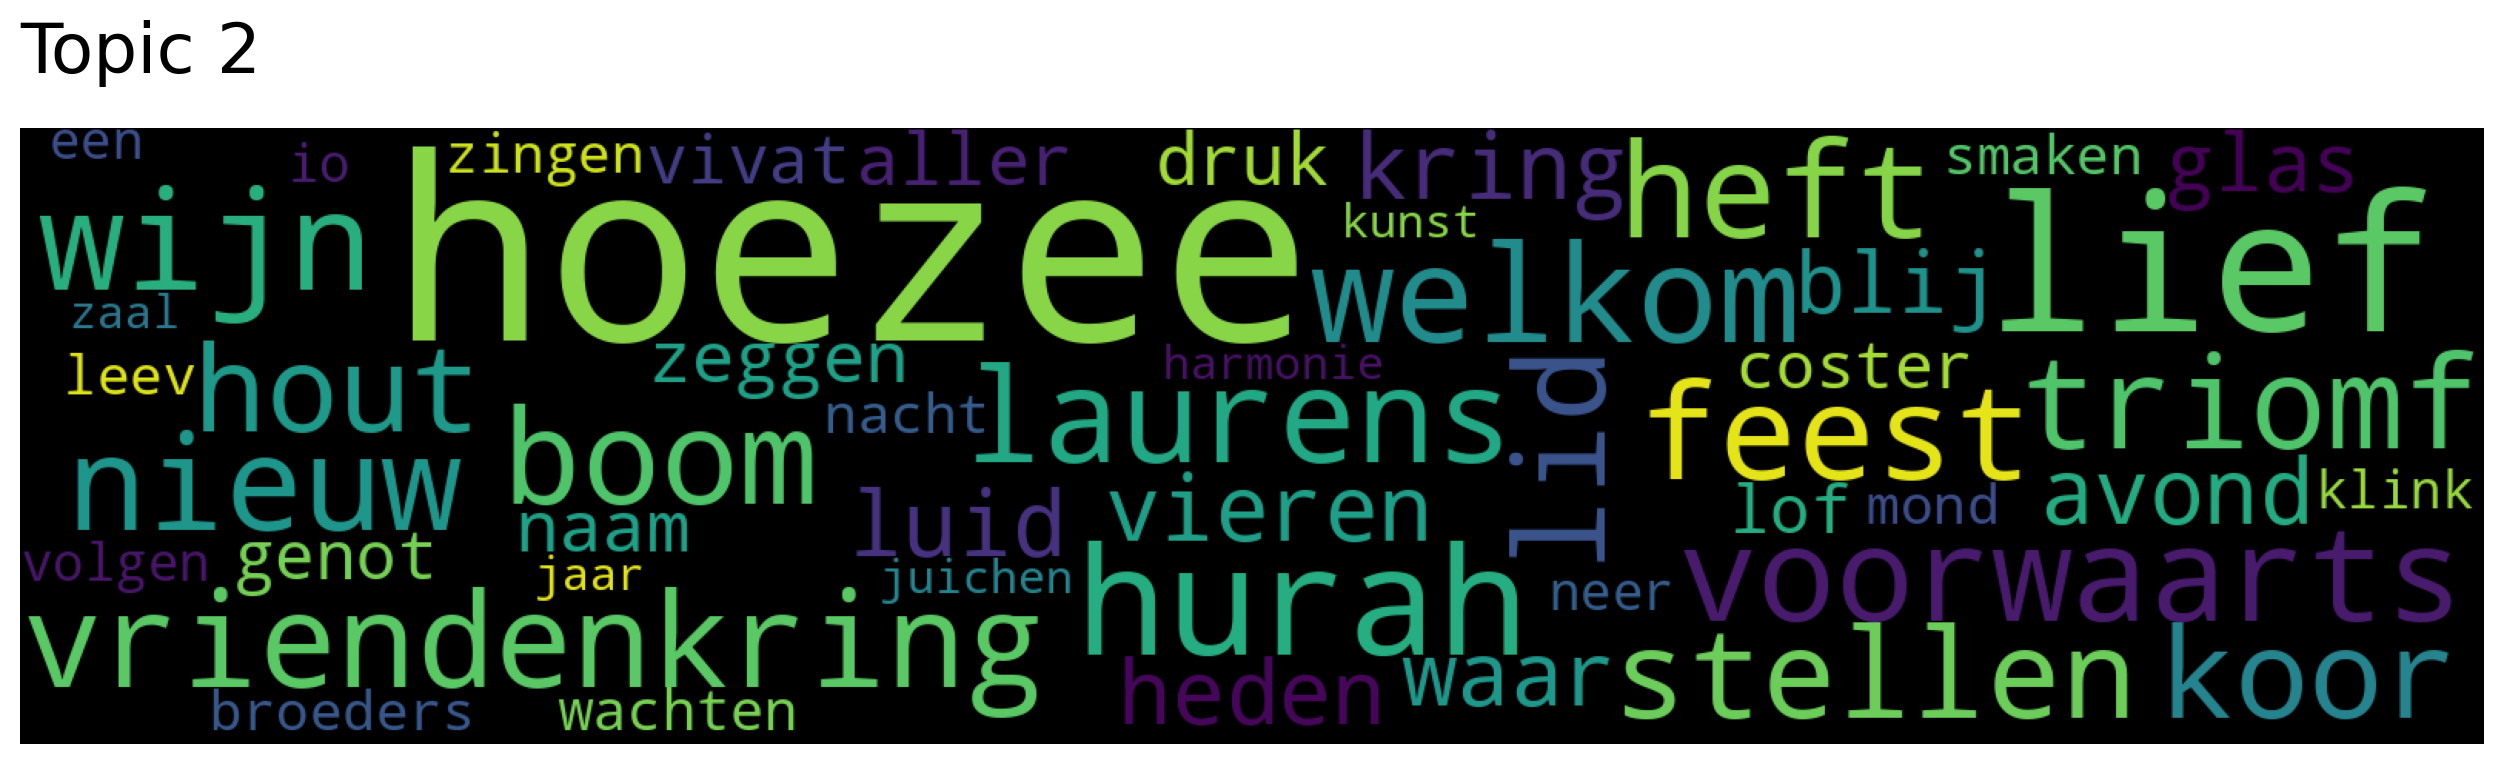

In [42]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [21]:
model.get_documents_topics([8])

(array([0]),
 array([0.94301856], dtype=float32),
 array([['juichtoon', 'toon', 'zonen', 'deugd', 'rijzen', 'haarlems',
         'stad', 'geven', 'mee', 'boekdrukkunst', 'pers', 'willen',
         'zegen', 'heen', 'oog', 'borst', 'hooger', 'aard', 'roemen',
         'vinding', 'kunst', 'roemt', 'heil', 'groot', 'god', 'waarde',
         'schoone', 'eeuw', 'neen', 'gunst', 'mond', 'bestaan', 'band',
         'naam', 'hand', 'brgen', 'deel', 'heel', 'man', 'nut', 'zaak',
         'aarde', 'verblijden', 'hart', 'gewis', 'zaam', 'grond',
         'schoon', 'mgen', 'kracht']], dtype='<U13'),
 array([[0.99640274, 0.996223  , 0.9957208 , 0.995656  , 0.9950299 ,
         0.9945671 , 0.9945498 , 0.9945438 , 0.9943709 , 0.99414295,
         0.99412584, 0.99412555, 0.99405164, 0.99404466, 0.99353284,
         0.9934971 , 0.9934082 , 0.9933482 , 0.99300116, 0.99288994,
         0.992811  , 0.99260896, 0.9924481 , 0.9924095 , 0.99219906,
         0.9921933 , 0.9921843 , 0.9920866 , 0.9920351 , 0.99

In [44]:
doc_ids = list(range(0, len(liedjesDF)))
topics, topic_scores, topic_words, words_score = model.get_documents_topics(doc_ids)

liedjesDF['topic'] = topics
liedjesDF['topic_score'] = topic_scores

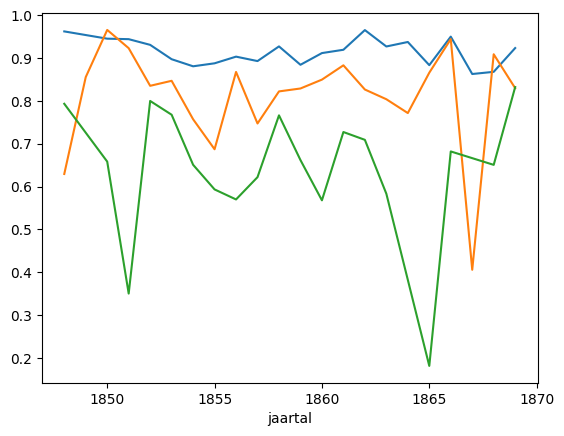

In [45]:
for topic in topic_nums:
    df = liedjesDF.loc[liedjesDF.topic == topic]
    dfAvg = df.groupby('jaartal').mean('topic_score')
    dfAvg['topic_score'].plot()


# Handmade topics
* nationalism: ["willem", "vaderland", "coster"]
* relation with patrons: ["donateur", "ereleden"]
* grievances ["loon", "zegel"]